In [1]:
import numpy as np
import pandas as pd
import pickle

In [ ]:
# sentiment_by_date = pickle.load(open("sentiment_by_date.pkl", "rb"))

In [ ]:
# daily_stock = pickle.load(open("daily_stock.pkl", "rb"))
# daily_stock[["AAPL"]].head(3)

In [ ]:
# aapl = sentiment_by_date.merge(daily_stock[["AAPL"]],
#              how="outer", 
#     right_index = True, 
#     left_index = True
# )

In [ ]:
# examine = predictors[["gold", "crude_oil", "futures_10"]].fillna(0.0)
# examine = examine.merge(aapl,
#              how="outer", 
#     right_index = True, 
#     left_index = True
# )
# examine = examine[~examine.AAPL.isnull()].fillna(0.0)

In [2]:
predictors = pickle.load(open("predictors.pkl", "rb"))
predictors = predictors[["gold", "crude_oil"]] #, "bit_cap"]]
predictors.head()

,gold,crude_oil
Date,,
1985-01-02,306.25,25.92
1985-01-03,299.50,25.84
1985-01-04,303.45,25.18
1985-01-07,296.75,25.56
1985-01-08,304.40,25.48


In [3]:
sp = pd.read_csv("GSPC.csv")
sp["sp500"] = (sp.Close - sp.Open) / sp.Open * 100
sp = sp[["Date", "sp500"]]
pd.DataFrame(sp.sp500).describe()

,sp500
count,17222.000000
mean,0.024305
std,0.887544
min,-20.466931
25%,-0.294164
50%,0.000000
75%,0.380907
max,10.789006


In [4]:
t10 = pd.read_csv("T10Y2Y_CHG.csv")
t10["T10Y2Y"] = t10["T10Y2Y_CHG"].str.replace(".", "0").astype(float)


In [5]:
df = t10.merge(predictors, how="right", left_on="DATE", right_index = True)
df = df.merge(sp, how="inner", left_on="DATE", right_on="Date")
df.drop(["Date", "DATE", "T10Y2Y_CHG"], axis=1, inplace=True)

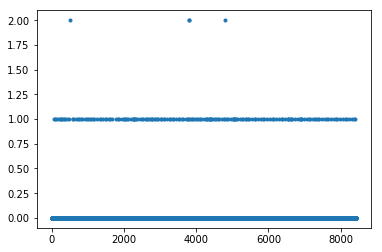

In [6]:
%matplotlib inline
df.isnull().sum(axis=1).plot(style=".")

In [7]:
df.head()

,T10Y2Y,gold,crude_oil,sp500
0,0.0,306.25,25.92,-1.094499
1,-11.0,299.50,25.84,-0.483756
2,3.0,303.45,25.18,-0.528721
3,-10.0,296.75,25.56,0.342138
4,-3.0,304.40,25.48,-0.152216


In [9]:
# Choose train / validation / split
# [ : val_slice : test_slice ]
val_slice = 6000
test_slice = 7500

# Normalize via training data only
df = (df - df[:val_slice].mean()) / df[:val_slice].std() 

# FIll with 0's. Note: the LSTM should learn that 0's represent missing values
df.fillna(0, inplace=True) 

float_data = np.array(df)
print(float_data.shape)
float_data

(8431, 4)


array([[ -5.62213566e-03,  -7.14530780e-01,  -2.21840227e-01,
         -1.04669860e+00],
       [ -3.20442346e+00,  -7.65199539e-01,  -2.25454442e-01,
         -4.81629037e-01],
       [  8.66778225e-01,  -7.35548932e-01,  -2.55271712e-01,
         -5.23230799e-01],
       ..., 
       [ -5.62213566e-03,   6.73903133e+00,   1.57713508e+00,
          4.07175420e-01],
       [  2.85177985e-01,   6.71538591e+00,   1.59339905e+00,
          2.65210389e-02],
       [ -5.87222376e-01,   6.73227549e+00,   1.60514524e+00,
          7.46877408e-03]])

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1] # -1 for the last var: sp500
        yield samples, targets

In [11]:
lookback = 30 # How many timesteps back the input data should go.
step = 1 # The period, in timesteps, at which you sample data. 
delay = 1 # How many timesteps in the future the target should be.
batch_size = 32 # Number big enough that it could be representatative of the whole 

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=val_slice,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=(val_slice+1),
                        max_index=test_slice,
                        step=step,
                        batch_size=batch_size)

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=test_slice+1,
                        max_index=None,
                        step=step,
                        batch_size=batch_size) #len(float_data) - (test_slice+1) )

val_steps = (test_slice - (val_slice+1) - lookback)
test_steps = (len(float_data) - (test_slice+1) - lookback)

In [12]:
print(val_steps, test_steps)
float_data.shape[-1] # number of variables

1469 900


4

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [62]:
model = Sequential()
# Can replace GRU with  simple RNN or LTSM for experimentation.
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1]) ))
                      #,recurrent_dropout = .5))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


In [63]:
history = model.fit_generator(train_gen,
                            steps_per_epoch=16, # 
                            epochs=8, # passes through the training data
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            verbose=1)

Epoch 1/8
16/16 [==============================] - 46s 3s/step - loss: 0.4997 - val_loss: 0.7647
Epoch 2/8
16/16 [==============================] - 44s 3s/step - loss: 0.5274 - val_loss: 0.7224
Epoch 3/8
16/16 [==============================] - 45s 3s/step - loss: 0.6838 - val_loss: 0.7404
Epoch 4/8
16/16 [==============================] - 44s 3s/step - loss: 0.8579 - val_loss: 0.7453
Epoch 5/8
16/16 [==============================] - 45s 3s/step - loss: 0.5535 - val_loss: 0.7394
Epoch 6/8
16/16 [==============================] - 45s 3s/step - loss: 0.6330 - val_loss: 0.7714
Epoch 7/8
16/16 [==============================] - 44s 3s/step - loss: 0.3920 - val_loss: 0.7718
Epoch 8/8
16/16 [==============================] - 45s 3s/step - loss: 0.4022 - val_loss: 0.7585


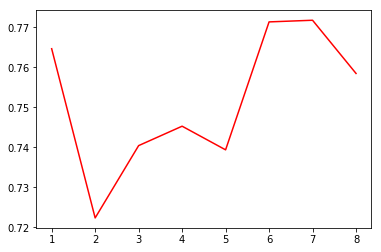

In [73]:
% matplotlib inline
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs, val_loss, 'r', label='Validation loss' )

val_slice
test_slice 

In [64]:
preds = model.predict_generator(test_gen, test_steps)
preds.shape

(28800, 1)

In [28]:
#float_data[-218:, -1]
#float_data[-218:][-1]

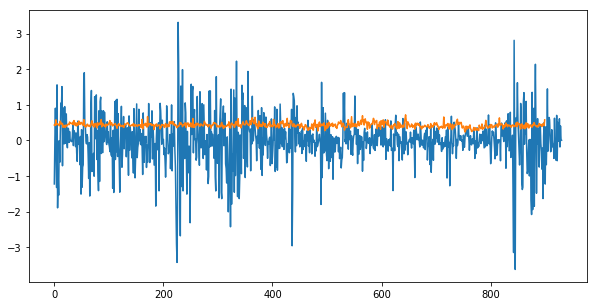

In [29]:
float_data.shape
#pd.DataFrame(float_data[0][-223:]).plot()
pd.Series(float_data[test_slice:, -1]).plot(figsize=(10,5))
pd.Series(preds[:test_steps, -1]).plot(figsize=(10,5))

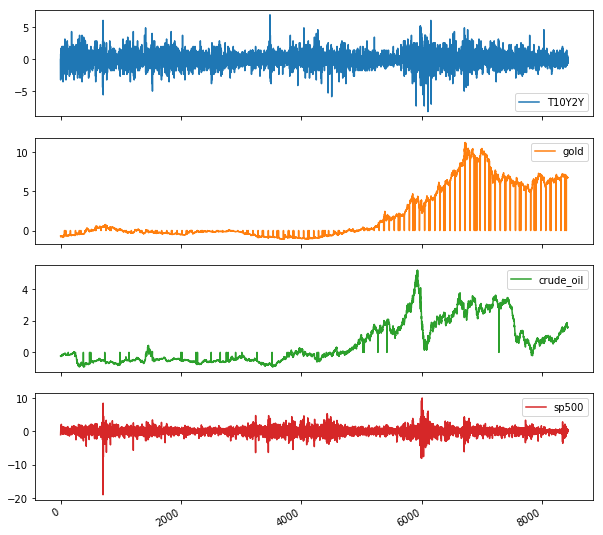

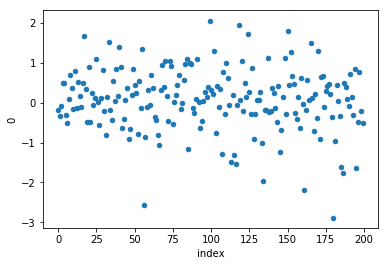

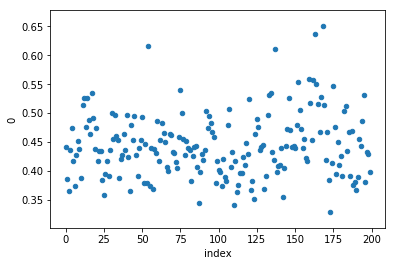

In [60]:
actual = pd.DataFrame(float_data[200:400, -1]).reset_index()
predicted = pd.DataFrame(preds[200:400, -1]).reset_index()


actual.plot.scatter(x="index", y=0)
predicted.plot.scatter(x="index", y=0)


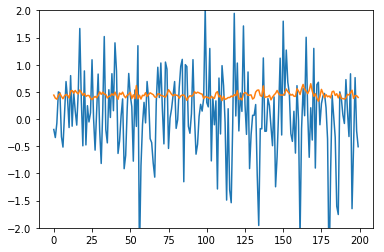

In [30]:
pd.Series(float_data[200:400, -1]).plot(ylim=(-2, 2))
pd.Series(preds[200:400, -1]).plot()


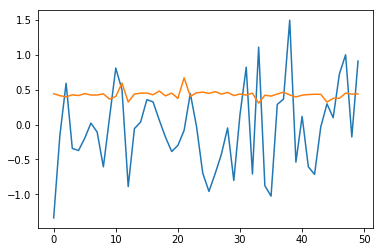

In [33]:
pd.Series(float_data[150:200, -1]).plot()
pd.Series(preds[150:200, -1]).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f86e6905588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f86e689fba8>], dtype=object)

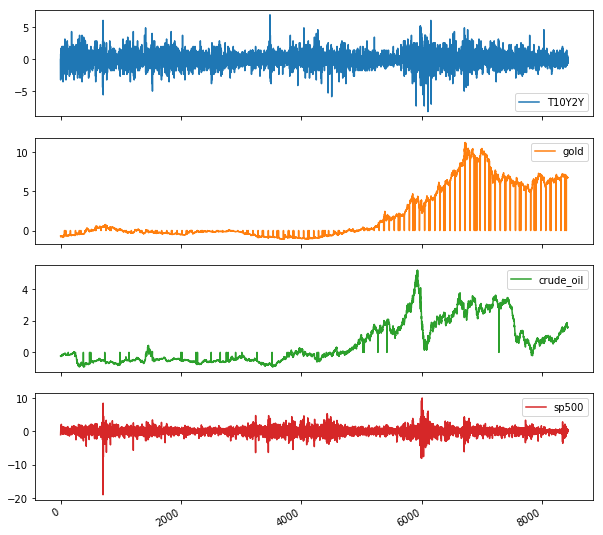

In [61]:
df.plot(subplots=True, figsize=(10, 10))